# Understanding Impact of a Behaviourally-Optimised Call Script on Customer Perceptions

In [77]:
# Load packages

from nlp import obtain_corpus, normalise_corpus, lda_topicmodel, plot_all_topics_grid, match_themes_from_corpus
import pandas as pd
from sentiment import analyse_sentiment_textblob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from clean_task2 import exclude_february, data_segmentation, parse_date_safe, clean_text_columns
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

### Data Cleaning

In [78]:
# Load data
df_control = pd.read_excel('../data_source/CDS_25_Task2.xlsx', 'C Control')
df_treatment = pd.read_excel('../data_source/CDS_25_Task2.xlsx', 'C Pilot')
print(df_treatment['TO_CHAR'].unique())
# Exclude February data
df_control = exclude_february(df_control)
df_treatment['TO_CHAR'] = df_treatment['TO_CHAR'].astype(str).str.replace(r'(?i)company', '02', regex=True)
df_treatment['TO_CHAR'] = df_treatment['TO_CHAR'].apply(parse_date_safe)
df_treatment = exclude_february(df_treatment)

[datetime.datetime(2023, 2, 1, 0, 0) '01/03/2company3' '01/04/2company3'
 '01/05/2company3' '01/06/2company3']


In [79]:
# Clean Text Columns
df_control = clean_text_columns(df_control)
df_treatment = clean_text_columns(df_treatment)

In [80]:
# Combine dataframes
df_combined = pd.concat([df_control, df_treatment], ignore_index=True)
# Segment the dataset into VOLT, non-VOLT, and their respective control and treatment groups
df_v, df_nv, df_v_control, df_nv_control, df_v_treatment, df_nv_treatment = data_segmentation(df_combined)

### Topic Modelling & Theme Discovery

In [81]:
# Load Corpus' to Analyse

general_corpus = obtain_corpus(df_combined)
general_corpus = normalise_corpus(general_corpus)

control_corpus = obtain_corpus(df_control)
control_corpus = normalise_corpus(control_corpus)

treatment_corpus = obtain_corpus(df_treatment)
treatment_corpus = normalise_corpus(treatment_corpus)

volt_corpus = obtain_corpus(df_v)
volt_corpus = normalise_corpus(volt_corpus)

nonvolt_corpus = obtain_corpus(df_nv)
nonvolt_corpus = normalise_corpus(nonvolt_corpus)

In [82]:
# General Corpus Topic Modelling

lda_general, general_matrix, general_features = lda_topicmodel(general_corpus, 12)

Topic #1 with weights
[(np.str_('informative'), 3.74), (np.str_('property'), 1.31), (np.str_('helpful'), 1.12), (np.str_('could'), 1.01), (np.str_('introduce'), 0.98), (np.str_('connect'), 0.95), (np.str_('perfect'), 0.93), (np.str_('etc'), 0.92)]
Topic #2 with weights
[(np.str_('percy'), 1.95), (np.str_('sort'), 1.92), (np.str_('easily'), 1.8), (np.str_('problem'), 1.35), (np.str_('everything'), 1.12), (np.str_('top'), 0.98), (np.str_('mark'), 0.98), (np.str_('listen'), 0.77)]
Topic #3 with weights
[(np.str_('connection'), 1.34), (np.str_('center'), 0.92), (np.str_('voice'), 0.88), (np.str_('feel'), 0.85), (np.str_('good'), 0.84), (np.str_('operator'), 0.8), (np.str_('say'), 0.67), (np.str_('reasonably'), 0.64)]
Topic #4 with weights
[(np.str_('super'), 0.93), (np.str_('what'), 0.56), (np.str_('ap'), 0.56), (np.str_('two'), 0.46), (np.str_('day'), 0.37), (np.str_('olivia'), 0.08), (np.str_('quick'), 0.08), (np.str_('complicated'), 0.08)]
Topic #5 with weights
[(np.str_('prompt'), 3.73

/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymon

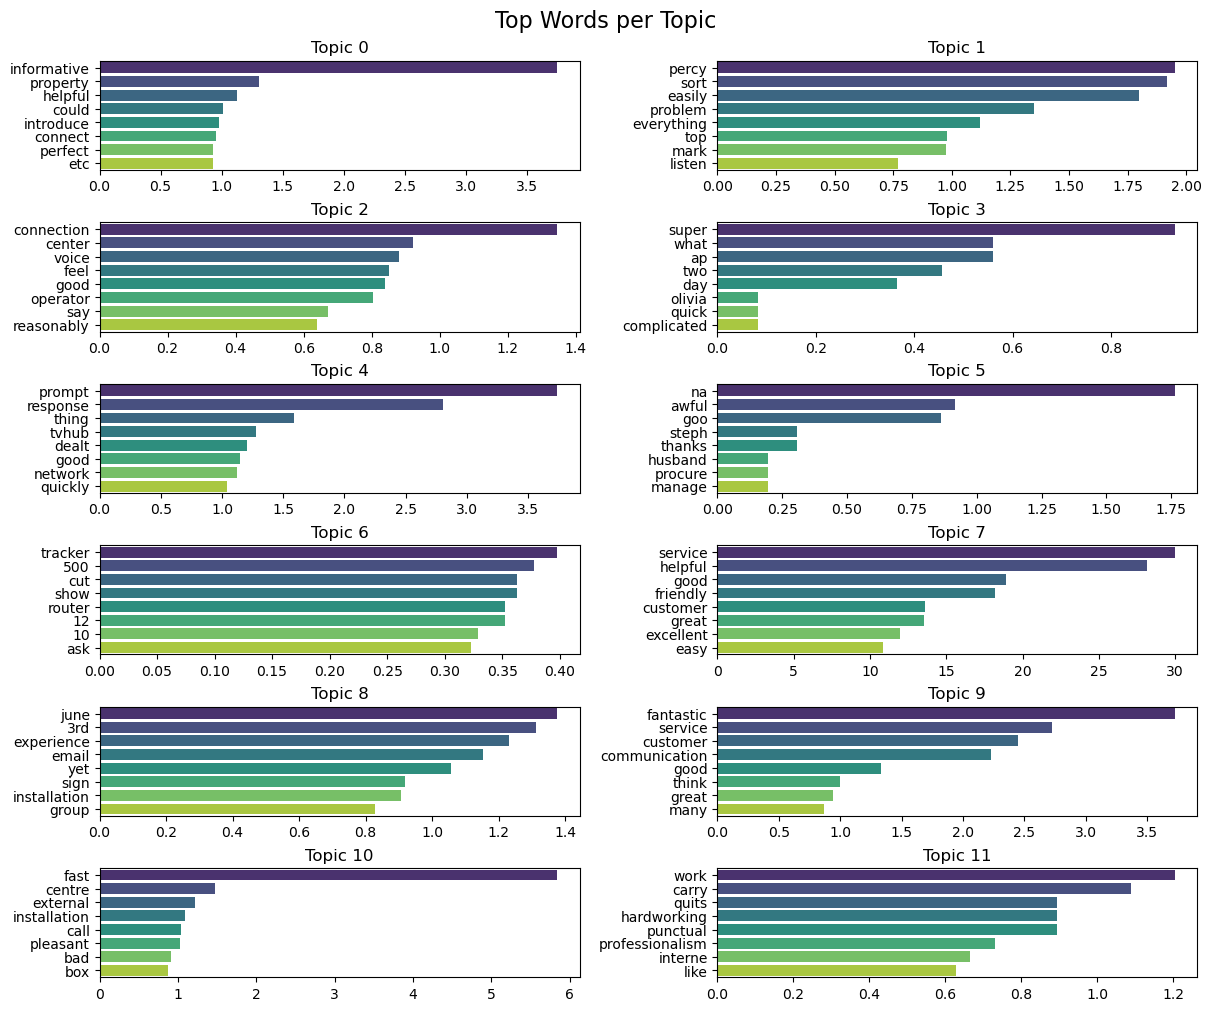

In [83]:
plot_all_topics_grid(lda_general, general_features)

In [84]:
# Treatment Corpus Topic Modelling
lda_treatment, treatment_matrix, treatment_features = lda_topicmodel(treatment_corpus, 12)

Topic #1 with weights
[(np.str_('8y'), 0.68), (np.str_('provider'), 0.68), (np.str_('match'), 0.68), (np.str_('package'), 0.65), (np.str_('satisfied'), 0.64), (np.str_('round'), 0.64), (np.str_('previous'), 0.6), (np.str_('brilliant'), 0.6)]
Topic #2 with weights
[(np.str_('informative'), 2.45), (np.str_('fantastic'), 1.72), (np.str_('helpful'), 0.88), (np.str_('service'), 0.77), (np.str_('adviser'), 0.69), (np.str_('polite'), 0.51), (np.str_('young'), 0.37), (np.str_('respectful'), 0.37)]
Topic #3 with weights
[(np.str_('service'), 9.23), (np.str_('great'), 5.42), (np.str_('customer'), 5.35), (np.str_('efficient'), 5.18), (np.str_('good'), 4.98), (np.str_('excellent'), 4.37), (np.str_('set'), 4.01), (np.str_('company'), 3.49)]
Topic #4 with weights
[(np.str_('fast'), 2.99), (np.str_('prompt'), 2.27), (np.str_('response'), 1.73), (np.str_('installation'), 1.47), (np.str_('3rd'), 1.0), (np.str_('email'), 1.0), (np.str_('june'), 0.93), (np.str_('yet'), 0.88)]
Topic #5 with weights
[(np.s

/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymon

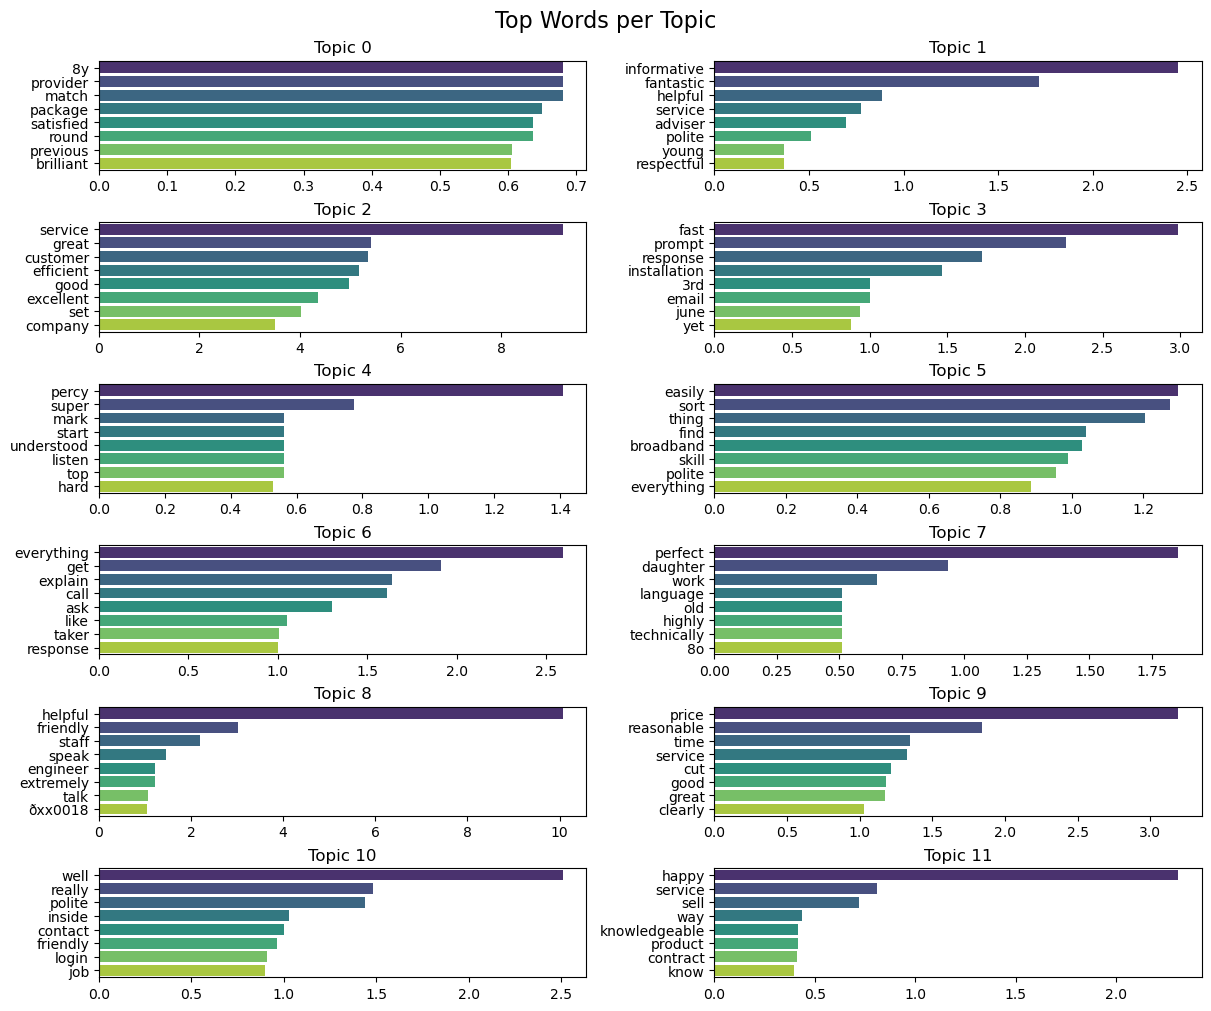

In [85]:
plot_all_topics_grid(lda_treatment, treatment_features)

In [86]:
# Control Corpus Topic Modelling
lda_control, control_matrix, control_features = lda_topicmodel(control_corpus, 12)

Topic #1 with weights
[(np.str_('nice'), 1.0), (np.str_('marco'), 0.96), (np.str_('indian'), 0.76), (np.str_('aswell'), 0.68), (np.str_('pleasent'), 0.68), (np.str_('centre'), 0.68), (np.str_('funny'), 0.62), (np.str_('ellie'), 0.62)]
Topic #2 with weights
[(np.str_('helpful'), 3.3), (np.str_('speak'), 1.96), (np.str_('internet'), 1.67), (np.str_('bad'), 1.05), (np.str_('polite'), 0.98), (np.str_('fast'), 0.98), (np.str_('charlotta'), 0.98), (np.str_('get'), 0.96)]
Topic #3 with weights
[(np.str_('fabulous'), 1.05), (np.str_('isn'), 0.55), (np.str_('let'), 0.55), (np.str_('many'), 0.54), (np.str_('referral'), 0.52), (np.str_('link'), 0.52), (np.str_('wouldn'), 0.52), (np.str_('enquiry'), 0.52)]
Topic #4 with weights
[(np.str_('helpful'), 1.25), (np.str_('informant'), 1.03), (np.str_('everyone'), 0.83), (np.str_('familiar'), 0.63), (np.str_('extremely'), 0.61), (np.str_('technology'), 0.6), (np.str_('wa'), 0.59), (np.str_('call'), 0.57)]
Topic #5 with weights
[(np.str_('don'), 1.46), (n

/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymondguo/Desktop/Careers/cowry interview/CowryDS/scripts/nlp.py:260: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_terms, ax=ax, palette='viridis')
/Users/raymon

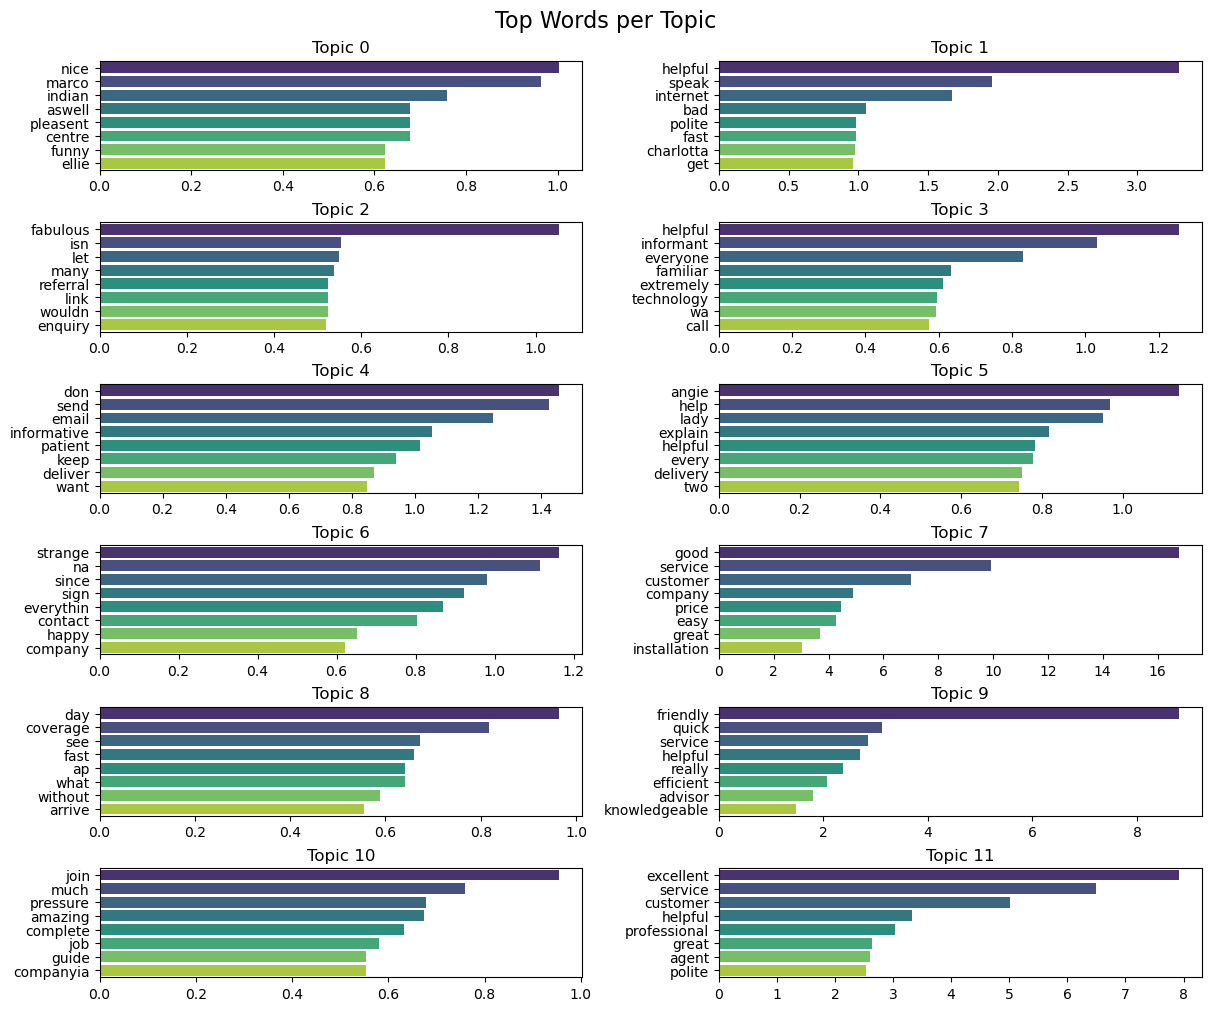

In [87]:
plot_all_topics_grid(lda_control, control_features)

In [88]:
# Zero-Shot Theme Extraction

model = SentenceTransformer('all-MiniLM-L6-v2')
themes = ["agent personality", "clarity", "reassurance"]
theme_embeddings = model.encode(themes, convert_to_tensor=True)

# General_corpus
df_results, theme_counts = match_themes_from_corpus(general_corpus, model, themes, theme_embeddings)

print(df_results)
print("\nTheme percentages:")
print(theme_counts)


                                               comment      matched_theme  \
0                                         good package        reassurance   
1                                good customer service        reassurance   
2    far good charlie efficient helpful let¬ hope c...        reassurance   
3                                  great communication            clarity   
4                chris amaze contact put detail online        reassurance   
..                                                 ...                ...   
425  new company medium say yet like service set ac...  agent personality   
426                                          efficient            clarity   
427                                helpful informative            clarity   
428  gentleman deal us helpful friendly deserve lot...  agent personality   
429  really easy get deal want really friendly staf...  agent personality   

     confidence  
0         0.262  
1         0.203  
2         0.253  
3  

In [89]:
# Treatment_corpus
df_results, theme_counts = match_themes_from_corpus(treatment_corpus, model, themes, theme_embeddings)

print(df_results)
print("\nTheme percentages:")
print(theme_counts)

                                               comment      matched_theme  \
0                                       prompt service  agent personality   
1    young man visit set internet respectful inform...            clarity   
2    internet isn¬ work team pushy despite put acco...  agent personality   
3                                         good service            clarity   
4    give 10 set tv broadband package one employeri...            clarity   
..                                                 ...                ...   
174  new company medium say yet like service set ac...  agent personality   
175                                          efficient            clarity   
176                                helpful informative            clarity   
177  gentleman deal us helpful friendly deserve lot...  agent personality   
178  really easy get deal want really friendly staf...  agent personality   

     confidence  
0         0.160  
1         0.224  
2         0.188  
3  

In [90]:
# Control_corpus
df_results, theme_counts = match_themes_from_corpus(control_corpus, model, themes, theme_embeddings)

print(df_results)
print("\nTheme percentages:")
print(theme_counts)

                                               comment      matched_theme  \
0                                         good package        reassurance   
1                                good customer service        reassurance   
2    far good charlie efficient helpful let¬ hope c...        reassurance   
3                                  great communication            clarity   
4                chris amaze contact put detail online        reassurance   
..                                                 ...                ...   
246                                  cant get box work  agent personality   
247  helpful efficient service competitive broadban...            clarity   
248  terrible customer service week later wifi stil...        reassurance   
249  good customer service agent find us really goo...            clarity   
250  reson one emplyee rosie help go extra mile pho...        reassurance   

     confidence  
0         0.262  
1         0.203  
2         0.253  
3  

### Sentiment Analysis

In [91]:
def run_sentiment_pipeline(corpus):
    valid_docs = [(i, doc) for i, doc in enumerate(corpus) if isinstance(doc, str) and doc.strip()]
    valid_indices = [i for i, _ in valid_docs]
    filtered_corpus = [doc for _, doc in valid_docs]
    sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in filtered_corpus]
    sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
    sentiment_df = pd.DataFrame({
        'index': valid_indices,
        'document': filtered_corpus,
        'sentiment_label': sentiment_labels,
        'polarity': polarities,
        'subjectivity': subjectivities
    }).set_index('index').sort_index()
    return sentiment_df, valid_indices

In [92]:
sentiment_df, valid_indices = run_sentiment_pipeline(general_corpus)
sentiment_treatment, treatment_indices = run_sentiment_pipeline(treatment_corpus)
sentiment_control, control_indices = run_sentiment_pipeline(control_corpus)
sentiment_volt, _ = run_sentiment_pipeline(volt_corpus)
sentiment_nonvolt, _ = run_sentiment_pipeline(nonvolt_corpus)

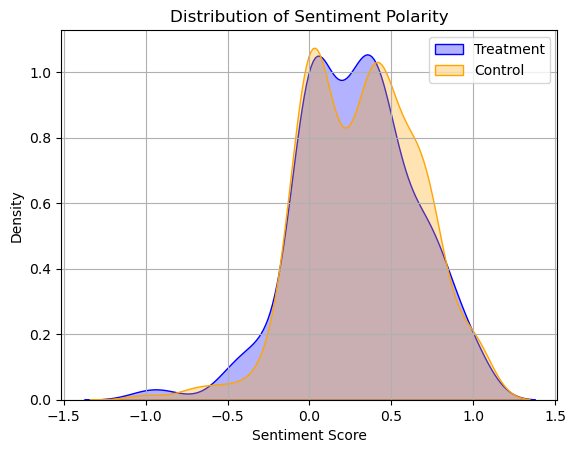

In [93]:
# Plot the sentiment distribution for treatment vs control (polarity)

sns.kdeplot(sentiment_treatment['polarity'], label='Treatment', color='blue', fill=True, alpha=0.3)
sns.kdeplot(sentiment_control['polarity'], label='Control', color='orange', fill=True, alpha=0.3)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Polarity')
plt.legend()
plt.grid(True)
plt.show()

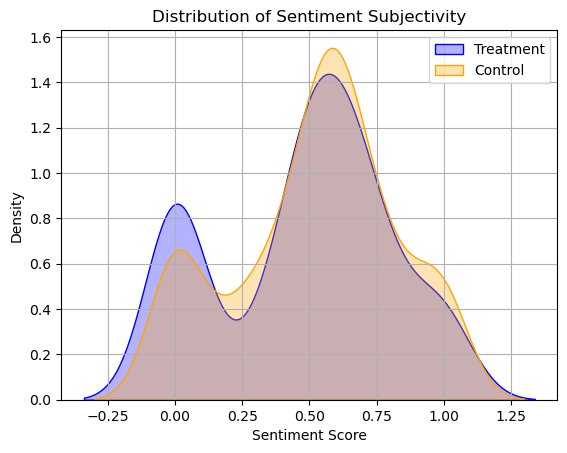

In [94]:
# Plot the sentiment distribution for treatment vs control (subjectivity)

sns.kdeplot(sentiment_treatment['subjectivity'], label='Treatment', color='blue', fill=True, alpha=0.3)
sns.kdeplot(sentiment_control['subjectivity'], label='Control', color='orange', fill=True, alpha=0.3)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Subjectivity')
plt.legend()
plt.grid(True)
plt.show()

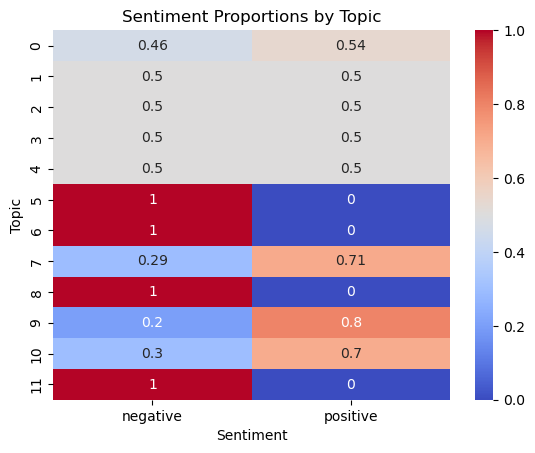

In [95]:
general_topics = lda_general.transform(general_matrix)
dominant_general = np.argmax(general_topics, axis=1)
sentiment_df['dominant_general'] = dominant_general
topic_sentiment_counts = sentiment_df.groupby(['dominant_general', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
sns.heatmap(topic_sentiment_props, annot=True, cmap='coolwarm')
plt.title('Sentiment Proportions by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

In [96]:
def print_top_terms_for_topic(topic_idx, top_n=10):
    topic_weights = lda_general.components_[topic_idx]
    top_indices = topic_weights.argsort()[::-1][:top_n]
    terms = [general_features[i] for i in top_indices]
    return terms

# Add to dataframe
coef_df['Top Words'] = coef_df['Topic'].apply(lambda t: print_top_terms_for_topic(int(t.split()[1])))

coef_df[['Topic', 'Coefficient', 'Top Words']]


,Topic,Coefficient,Top Words
2,Topic 2,0.462570,"[connection, center, voice, feel, good, operat..."
1,Topic 1,0.403694,"[percy, sort, easily, problem, everything, top..."
0,Topic 0,0.356209,"[informative, property, helpful, could, introd..."
5,Topic 5,0.086575,"[na, awful, goo, steph, thanks, husband, procu..."
4,Topic 4,0.031112,"[prompt, response, thing, tvhub, dealt, good, ..."
8,Topic 8,0.028365,"[june, 3rd, experience, email, yet, sign, inst..."
7,Topic 7,-0.072445,"[service, helpful, good, friendly, customer, g..."
3,Topic 3,-0.108134,"[super, what, ap, two, day, olivia, quick, com..."
6,Topic 6,-0.316441,"[tracker, 500, cut, show, router, 12, 10, ask,..."
9,Topic 9,-0.862924,"[fantastic, service, customer, communication, ..."


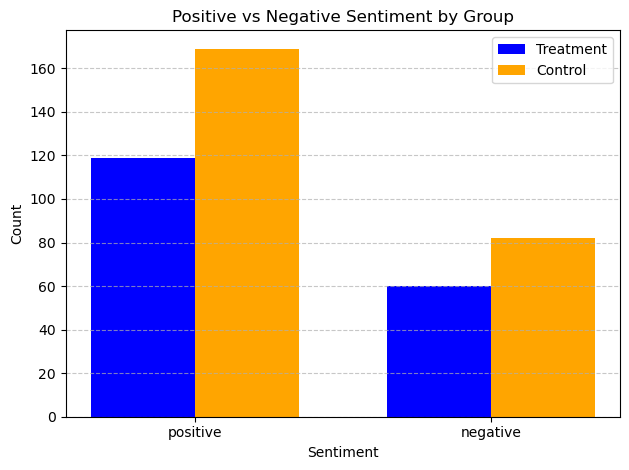

In [97]:
treatment_counts = sentiment_treatment['sentiment_label'].value_counts()
control_counts = sentiment_control['sentiment_label'].value_counts()

labels = ['positive', 'negative']
treatment_vals = [treatment_counts.get(label, 0) for label in labels]
control_vals = [control_counts.get(label, 0) for label in labels]

x = np.arange(len(labels))
width = 0.35

plt.bar(x - width/2, treatment_vals, width, label='Treatment', color='blue')
plt.bar(x + width/2, control_vals, width, label='Control', color='orange')

plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Positive vs Negative Sentiment by Group')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#### VOLT vs General

In [98]:
sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in volt_corpus]
sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
sentiment_volt = pd.DataFrame({
    'document': volt_corpus,
    'sentiment_label': sentiment_labels,
    'polarity': polarities,
    'subjectivity': subjectivities
})
sentiment_volt

,document,sentiment_label,polarity,subjectivity
0,good customer service,positive,0.70,0.60
1,far good charlie efficient helpful let¬ hope c...,positive,0.43,0.81
2,chris amaze contact put detail online,negative,0.00,0.00
3,price bundle go 2 day place order,negative,0.00,0.00
4,simple straightforward process lot information...,positive,0.19,0.37
...,...,...,...,...
167,great service phone brilliant package previous...,positive,0.37,0.66
168,advisor explain everything clearly detailhe he...,positive,0.29,0.56
169,like quick response get everything,positive,0.33,0.50
170,great service engineer come next day lovely ge...,positive,0.43,0.50


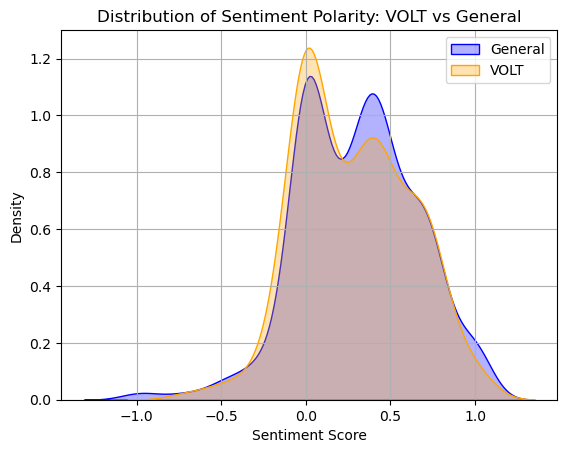

In [99]:
# Plot the sentiment distribution for VOLT vs General

sns.kdeplot(sentiment_df['polarity'], label='General', color='blue', fill=True, alpha=0.3)
sns.kdeplot(sentiment_volt['polarity'], label='VOLT', color='orange', fill=True, alpha=0.3)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Polarity: VOLT vs General')
plt.legend()
plt.grid(True)
plt.show()

In [100]:
sentiment_df.describe()

,polarity,subjectivity,dominant_general
count,430.000000,430.000000,430.000000
mean,0.301651,0.501070,6.762791
std,0.349335,0.307465,1.777747
min,-1.000000,0.000000,0.000000
25%,0.000000,0.312500,7.000000
50%,0.335000,0.550000,7.000000
75%,0.540000,0.700000,7.000000
max,1.000000,1.000000,11.000000


In [101]:
sentiment_volt.describe()

,polarity,subjectivity
count,172.000000,172.000000
mean,0.278721,0.496163
std,0.330207,0.317388
min,-0.700000,0.000000
25%,0.000000,0.312500
50%,0.265000,0.555000
75%,0.510000,0.700000
max,1.000000,1.000000


In [102]:
sentiment_results = [analyse_sentiment_textblob(doc, verbose=False) for doc in nonvolt_corpus]
sentiment_labels, polarities, subjectivities = zip(*sentiment_results)
sentiment_nonvolt = pd.DataFrame({
    'document': nonvolt_corpus,
    'sentiment_label': sentiment_labels,
    'polarity': polarities,
    'subjectivity': subjectivities
})
sentiment_nonvolt

,document,sentiment_label,polarity,subjectivity
0,good package,positive,0.70,0.60
1,great communication,positive,0.80,0.75
2,amazing service job complete,positive,0.35,0.65
3,goo service,negative,0.00,0.00
4,guy speak helpful give fantastic deal look for...,positive,0.40,0.63
...,...,...,...,...
253,daughter go everything operator 8o year old un...,positive,0.23,0.39
254,new company medium say yet like service set ac...,positive,0.14,0.45
255,efficient,negative,0.00,0.00
256,gentleman deal us helpful friendly deserve lot...,positive,0.49,0.75


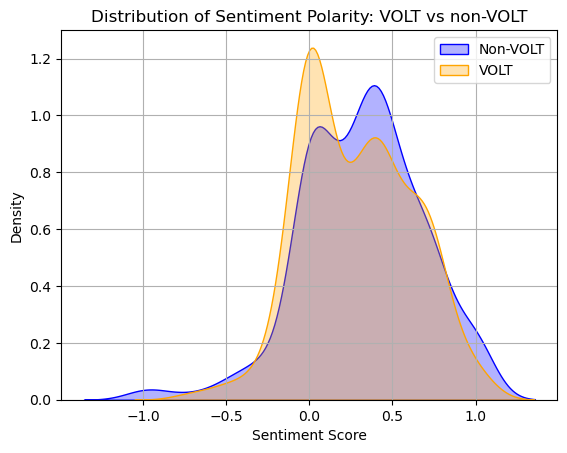

In [103]:
sns.kdeplot(sentiment_nonvolt['polarity'], label='Non-VOLT', color='blue', fill=True, alpha=0.3)
sns.kdeplot(sentiment_volt['polarity'], label='VOLT', color='orange', fill=True, alpha=0.3)

plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.title('Distribution of Sentiment Polarity: VOLT vs non-VOLT')
plt.legend()
plt.grid(True)
plt.show()

In [104]:
sentiment_nonvolt.describe()

,polarity,subjectivity
count,258.000000,258.000000
mean,0.316938,0.504341
std,0.361347,0.301249
min,-1.000000,0.000000
25%,0.000000,0.315000
50%,0.350000,0.550000
75%,0.540000,0.710000
max,1.000000,1.000000


#### Topics that co-occur with negative and positive sentiments

To do this, we use the original topic model and assign dominant topics to dataframes

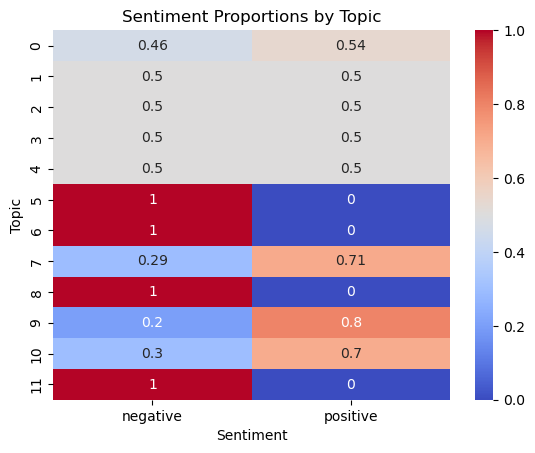

In [105]:
general_topics = lda_general.transform(general_matrix)
dominant_general = np.argmax(general_topics, axis=1)
sentiment_df['dominant_general'] = dominant_general
topic_sentiment_counts = sentiment_df.groupby(['dominant_general', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
sns.heatmap(topic_sentiment_props, annot=True, cmap='coolwarm')
plt.title('Sentiment Proportions by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

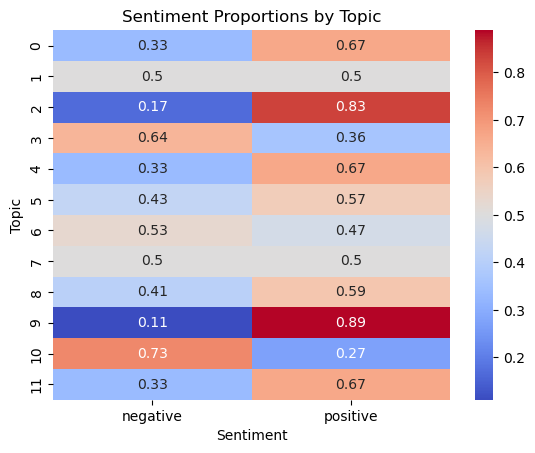

In [106]:
treatment_topics = lda_treatment.transform(treatment_matrix)
dominant_treatment = np.argmax(treatment_topics, axis=1)
sentiment_treatment['dominant_treatment'] = dominant_treatment
topic_sentiment_counts = sentiment_treatment.groupby(['dominant_treatment', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
sns.heatmap(topic_sentiment_props, annot=True, cmap='coolwarm')
plt.title('Sentiment Proportions by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

In [107]:
coef_df['Topic Index'] = coef_df['Topic'].str.extract(r'(\d+)').astype(int)
coef_table = coef_df[['Topic Index', 'Coefficient', 'Top Words']].sort_values('Topic Index')

# Display the table
print(coef_table.to_string(index=False))


 Topic Index  Coefficient                                                                              Top Words
           0     0.356209  [informative, property, helpful, could, introduce, connect, perfect, etc, 50, friend]
           1     0.403694        [percy, sort, easily, problem, everything, top, mark, listen, hard, understood]
           2     0.462570  [connection, center, voice, feel, good, operator, say, reasonably, alright, internet]
           3    -0.108134      [super, what, ap, two, day, olivia, quick, complicated, conversation, understand]
           4     0.031112              [prompt, response, thing, tvhub, dealt, good, network, quickly, set, guy]
           5     0.086575            [na, awful, goo, steph, thanks, husband, procure, manage, extreme, somehow]
           6    -0.316441                         [tracker, 500, cut, show, router, 12, 10, ask, send, internet]
           7    -0.072445 [service, helpful, good, friendly, customer, great, excellent, easy, e

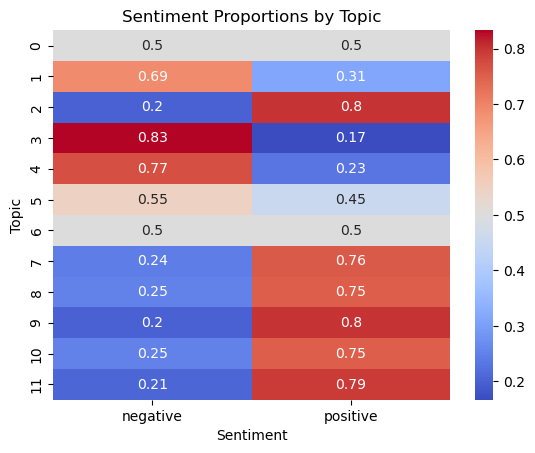

In [108]:
control_topics = lda_control.transform(control_matrix)
dominant_control = np.argmax(control_topics, axis=1)
sentiment_control['dominant_control'] = dominant_control
topic_sentiment_counts = sentiment_control.groupby(['dominant_control', 'sentiment_label']).size().unstack(fill_value=0)
topic_sentiment_props = topic_sentiment_counts.div(topic_sentiment_counts.sum(axis=1), axis=0)
sns.heatmap(topic_sentiment_props, annot=True, cmap='coolwarm')
plt.title('Sentiment Proportions by Topic')
plt.xlabel('Sentiment')
plt.ylabel('Topic')
plt.show()

In [109]:
coef_df['Topic Index'] = coef_df['Topic'].str.extract(r'(\d+)').astype(int)
coef_table = coef_df[['Topic Index', 'Coefficient', 'Top Words']].sort_values('Topic Index')

# Display the table
print(coef_table.to_string(index=False))

 Topic Index  Coefficient                                                                              Top Words
           0     0.356209  [informative, property, helpful, could, introduce, connect, perfect, etc, 50, friend]
           1     0.403694        [percy, sort, easily, problem, everything, top, mark, listen, hard, understood]
           2     0.462570  [connection, center, voice, feel, good, operator, say, reasonably, alright, internet]
           3    -0.108134      [super, what, ap, two, day, olivia, quick, complicated, conversation, understand]
           4     0.031112              [prompt, response, thing, tvhub, dealt, good, network, quickly, set, guy]
           5     0.086575            [na, awful, goo, steph, thanks, husband, procure, manage, extreme, somehow]
           6    -0.316441                         [tracker, 500, cut, show, router, 12, 10, ask, send, internet]
           7    -0.072445 [service, helpful, good, friendly, customer, great, excellent, easy, e

### Classification Model

In [110]:
sentiment_df['sentiment_label'].value_counts()

sentiment_label
positive    288
negative    142
Name: count, dtype: int64

In [111]:
general_topics[valid_indices].shape

(430, 12)

In [112]:
sentiment_df['sentiment_label'].shape

(430,)

              precision    recall  f1-score   support

           0       0.67      0.26      0.37        31
           1       0.69      0.93      0.79        55

    accuracy                           0.69        86
   macro avg       0.68      0.59      0.58        86
weighted avg       0.68      0.69      0.64        86



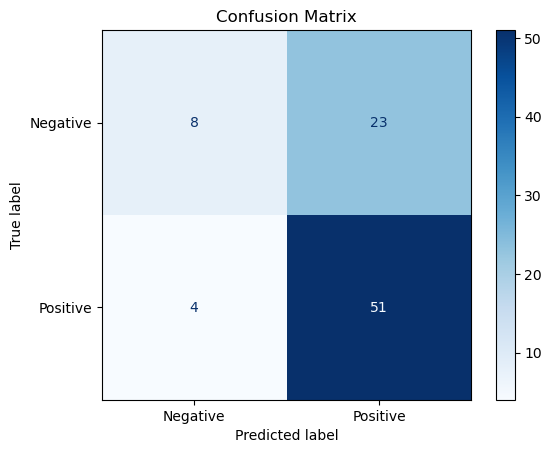

In [113]:
# Train base classification model with logistic regression
filtered_topic_distributions = general_topics[valid_indices]
binary_labels = [1 if label == 'positive' else 0 for label in sentiment_df['sentiment_label']]
X_train, X_test, y_train, y_test = train_test_split(filtered_topic_distributions, binary_labels, test_size=0.2, random_state=42)

clf = LogisticRegression(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [114]:
topic_names = [f"Topic {i}" for i in range(filtered_topic_distributions.shape[1])]
coefs = clf.coef_[0]

coef_df = pd.DataFrame({
    'Topic': topic_names,
    'Coefficient': coefs
}).sort_values(by='Coefficient', ascending=False)

print(coef_df)

       Topic  Coefficient
9    Topic 9     1.070852
7    Topic 7     0.906135
4    Topic 4     0.711157
10  Topic 10     0.528226
0    Topic 0     0.069099
3    Topic 3    -0.037683
2    Topic 2    -0.197310
1    Topic 1    -0.202142
6    Topic 6    -0.273337
5    Topic 5    -0.463079
8    Topic 8    -0.949677
11  Topic 11    -1.202586


/var/folders/2p/cx67y4vd2kv480_swjmtqf040000gn/T/ipykernel_4266/4270618204.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Topic', palette='coolwarm')


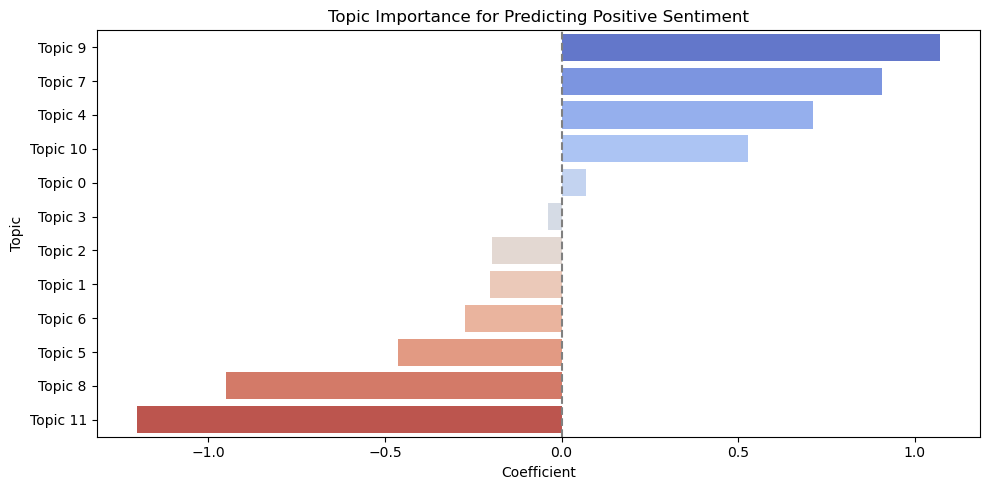

In [115]:
plt.figure(figsize=(10, 5))
sns.barplot(data=coef_df, x='Coefficient', y='Topic', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Topic Importance for Predicting Positive Sentiment')
plt.tight_layout()
plt.show()

In [116]:
def print_top_terms_for_topic(topic_idx, top_n=10):
    topic_weights = lda_general.components_[topic_idx]
    top_indices = topic_weights.argsort()[::-1][:top_n]
    terms = [general_features[i] for i in top_indices]
    return terms

# Add to dataframe
coef_df['Top Words'] = coef_df['Topic'].apply(lambda t: print_top_terms_for_topic(int(t.split()[1])))

coef_df[['Topic', 'Coefficient', 'Top Words']]


,Topic,Coefficient,Top Words
9,Topic 9,1.070852,"[fantastic, service, customer, communication, ..."
7,Topic 7,0.906135,"[service, helpful, good, friendly, customer, g..."
4,Topic 4,0.711157,"[prompt, response, thing, tvhub, dealt, good, ..."
10,Topic 10,0.528226,"[fast, centre, external, installation, call, p..."
0,Topic 0,0.069099,"[informative, property, helpful, could, introd..."
3,Topic 3,-0.037683,"[super, what, ap, two, day, olivia, quick, com..."
2,Topic 2,-0.197310,"[connection, center, voice, feel, good, operat..."
1,Topic 1,-0.202142,"[percy, sort, easily, problem, everything, top..."
6,Topic 6,-0.273337,"[tracker, 500, cut, show, router, 12, 10, ask,..."
5,Topic 5,-0.463079,"[na, awful, goo, steph, thanks, husband, procu..."
